In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import pandas_ta as ta
import matplotlib.pyplot as plt

import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import *
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()    

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 44% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% | 45% |


In [2]:
exportPath = './exports/'
marketPath = './'
imgPath = './exports/img/'
modelPath = './exports/model/'

In [3]:
def log_transform(df):
    # copy the dataframe
    tdf = df.copy()
    # apply log scaling
    for column in tdf.columns:
        tdf[column] = np.log(tdf[column])
    tdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    tdf = tdf.astype(float)
    tdf = tdf.interpolate(method='linear', axis=0).ffill().bfill()
    tdf = tdf.fillna(0)
    return tdf

def boxcox(df):
    # copy the dataframe
    _df = df.copy()
    # apply log scaling
    for column in _df.columns:
        _df[column] = boxcox1p(_df[column], 0.25)
    _df = _df.fillna(0)
    _df = _df.astype(float)
    return _df

def min_max_scaling(df):
    # copy the dataframe
    tdf = df.copy()
    # apply min-max scaling
    for column in tdf.columns:
        tdf[column] = (tdf[column] - tdf[column].min()) / (tdf[column].max() - tdf[column].min())
    tdf = tdf.fillna(0)
    return tdf


# --------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
#@@@@@@@@@@@@@@@@@@@@@@@@
#    Custom indicators
#@@@@@@@@@@@@@@@@@@@@@@@@


#------------------------------------------------------------------------------------------

# HRV: Heart rate variability - RMSSD: Root mean square of the successive differences

def rmssd(data):
    delta = data.shift(0) - data.shift(1) 
    delta *= delta
    return np.sqrt(delta / 2)

def lnrmssd(data):
    delta = data.shift(0) - data.shift(1) 
    delta *= delta
    return np.log(np.sqrt(delta / 2))



#------------------------------------------------------------------------------------------

# Local Hurst Exponent Approximation
# https://www.youtube.com/watch?v=QpH-YPin01k&t=793s
# https://usethinkscript.com/threads/local-hurst-exponent-for-thinkorswim.2480/ 

def LHEA(high, low, length):
    tr = high - low
    atr = tr.rolling(length).mean()
    hh = high.rolling(length).max()
    ll = low.rolling(length).min()
    H = (np.log(hh - ll) - np.log(atr)) / (np.log(length))
    return H



#------------------------------------------------------------------------------------------

def reverse_ema(y):

    y = y.rename("reverse_ema", inplace=True)
    
    aa = .1
    cc = 1 - aa

    ma = aa * y + cc * y.shift(1).interpolate(method='linear', limit_direction='both')
    r1 = cc * ma + ma.shift(1).interpolate(method='linear', limit_direction='both')
    r2 = np.power(cc, 2)   * r1 + r1.shift(1).interpolate(method='linear', limit_direction='both')
    r3 = np.power(cc, 4)   * r2 + r2.shift(1).interpolate(method='linear', limit_direction='both')
    r4 = np.power(cc, 8)   * r3 + r3.shift(1).interpolate(method='linear', limit_direction='both')
    r5 = np.power(cc, 16)  * r4 + r4.shift(1).interpolate(method='linear', limit_direction='both')
    r6 = np.power(cc, 32)  * r5 + r5.shift(1).interpolate(method='linear', limit_direction='both')
    r7 = np.power(cc, 64)  * r6 + r6.shift(1).interpolate(method='linear', limit_direction='both')
    r8 = np.power(cc, 128) * r7 + r7.shift(1).interpolate(method='linear', limit_direction='both')
    wa = ma - aa * r8

    # wa = wa.interpolate(method='linear', limit_direction='both', limit=1)
    
    return wa

#------------------------------------------------------------------------------------------

def gann_slope(high, low, close):
    c0 = (high + low + close) / 3
    a1 = c0.rolling(15).max()
    a2 = c0.rolling(15).min()
    a3 = a1 - a2
    gann_slope = ta.ema((c0 - a2) / a3, 2) * 100
    return gann_slope


Index(['open', 'high', 'low', 'close', 'y'], dtype='object')
2019-08-09 2023-01-03
Index([               'MACD_12_26_9',               'MACDh_12_26_9',
                     'MACDs_12_26_9',                'SUPERT_7_3.0',
                     'SUPERTd_7_3.0',               'SUPERTl_7_3.0',
                     'SUPERTs_7_3.0', 'KST_10_15_20_30_10_10_10_15',
                            'KSTs_9',                      'DPO_20',
                                   0,                 'reverse_ema',
                             'EMA_2'],
      dtype='object')


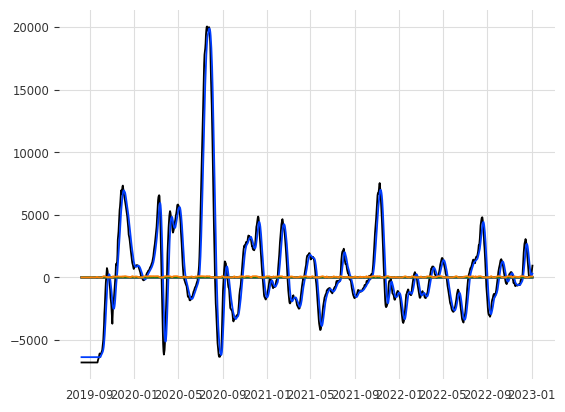

In [5]:
ticker = 'AMPL'

_df = pd.read_csv(marketPath + ticker + '_Data.csv',parse_dates = True,index_col=0)

_df = _df.rename(columns={
    "open": "open_price", 
    "high": "high_price", 
    "low": "low_price", 
    "close": "close_price"})


_df['open']  = _df['Market Cap'] * _df['open_price'] 
_df['high']  = _df['Market Cap'] * _df['high_price'] 
_df['low']   = _df['Market Cap'] * _df['low_price']  
_df['close'] = _df['Market Cap'] * _df['close_price']

_df['y'] = _df['Market Cap']

_df = _df.drop([
    # 'open',
    # 'high',
    # 'low',
    # 'close',    
    'open_price',
    'high_price',
    'low_price',
    'close_price',
    'Volume',
    'Market Cap'
], axis=1)

_df = log_transform(_df)
print(_df.columns)

macd = ta.macd(_df['y'])
supertrend = ta.supertrend(open=_df.open, high=_df.high, low=_df.low, close=_df.close)
kst = ta.kst(open=_df.open, high=_df.high, low=_df.low, close=_df.close)
stochrsi = ta.stochrsi(_df['y'])
atr = ta.atr(open=_df.open, high=_df.high, low=_df.low, close=_df.close)
dpo  = ta.dpo(open=_df.open, high=_df.high, low=_df.low, close=_df.close)


rmssd_data = ta.sma(rmssd(_df['y']), 1).rename("rmssd")
lnrmssd_data = ta.sma(lnrmssd(_df.low), 1).rename("lnrmssd")
lhea_data = LHEA(_df.high, _df.low, 10)
rema_data = reverse_ema(_df['y'])
gs_data = gann_slope(_df.high, low=_df.low, close=_df.close)

ta_df = pd.concat(
    [
        # _df,
        
        macd,
        supertrend,
        kst,
        # stochrsi,
        # atr,
        dpo,
        
        # rmssd_data, 
        # lnrmssd_data,
        lhea_data,     
        rema_data,
        gs_data,
    ],
    axis=1,
    # join="outer",
    # ignore_index=True,
    # keys=None,
    # levels=None,
    # names=None,
    # verify_integrity=False,
    # copy=True,
                   )


past_df = ta_df.interpolate(method='linear', limit_direction='both')
past_exog_list = past_df

#------------------------------------------------------------------------------------------

earliest = _df.index.min()
latest = _df.index.max()

earliest = earliest.strftime('%Y-%m-%d')
latest = latest.strftime('%Y-%m-%d')
print(earliest, latest)


#------------------------------------------------------------------------------------------

_df = _df.interpolate(method='linear', limit_direction='both')


print(past_df.columns)
plt.plot(past_df)

In [6]:
_df = log_transform(_df)
_df = min_max_scaling(_df)

past_df = min_max_scaling(past_df)

In [7]:
_df = _df.astype('float64')

past_df = past_df.astype('float64')


In [8]:
_df['time'] = _df.index.copy()

past_df['time'] = past_df.index.copy()

In [9]:
past_covariates = TimeSeries.from_dataframe(past_df, 'time', 
value_cols = list(filter(lambda x: x, past_df.columns)).remove('time')                           )

In [10]:
y = TimeSeries.from_dataframe(_df, 'time', 'y')

validation = round(len(y) * 0.236)
print(validation)
# Set aside the last 36 months as a validation series
train = y

294


In [11]:
ocl = 30
icl = round(ocl * 1.618)
# icl = 720

print(icl,ocl)

49 30


In [12]:
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)


currentModel = 'NLinearModel'
m = NLinearModel(
    
   pl_trainer_kwargs={'enable_progress_bar':True,
                      "accelerator": "gpu", "gpus": -1, "auto_select_gpus": True,
                      "callbacks": [my_stopper]
                     },    
    input_chunk_length=icl,
    output_chunk_length=ocl,
    random_state=1
)



In [13]:
m.fit(
    train, 
    past_covariates=past_covariates
)

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 20.6 K
---------------------------------------------------
20.6 K    Trainable params
0         Non-trainable params
20.6 K    Total params
0.165     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Auto select gpus: [0]
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


30 Day forecast



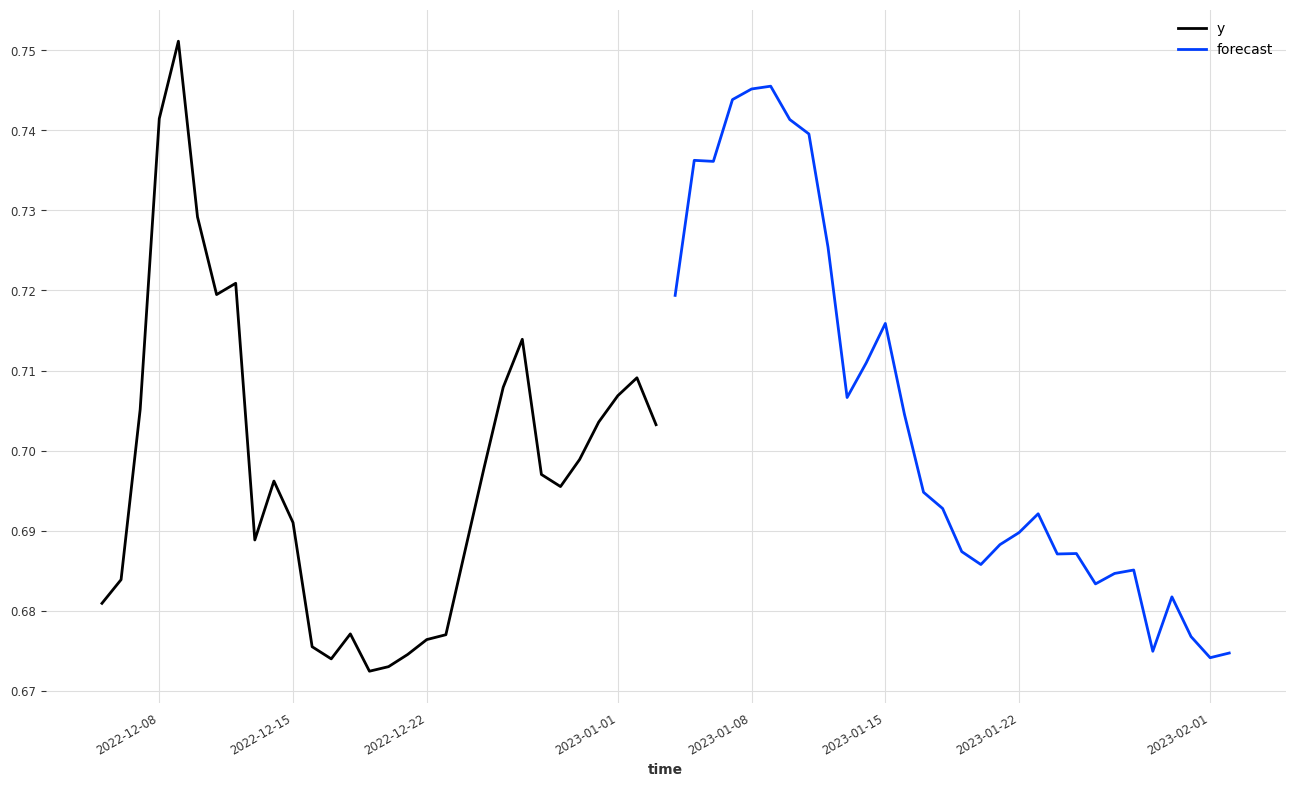

In [14]:
# %matplotlib notebook
%matplotlib inline

train_plot = train.tail(30)
forecast_len = ocl

fig, ax = plt.subplots(figsize=(16,9))

pred = m.predict(forecast_len)

train_plot.plot()
pred.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

print('\n' + str(forecast_len) + ' Day forecast\n')


2023-01-04 17:01:17 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


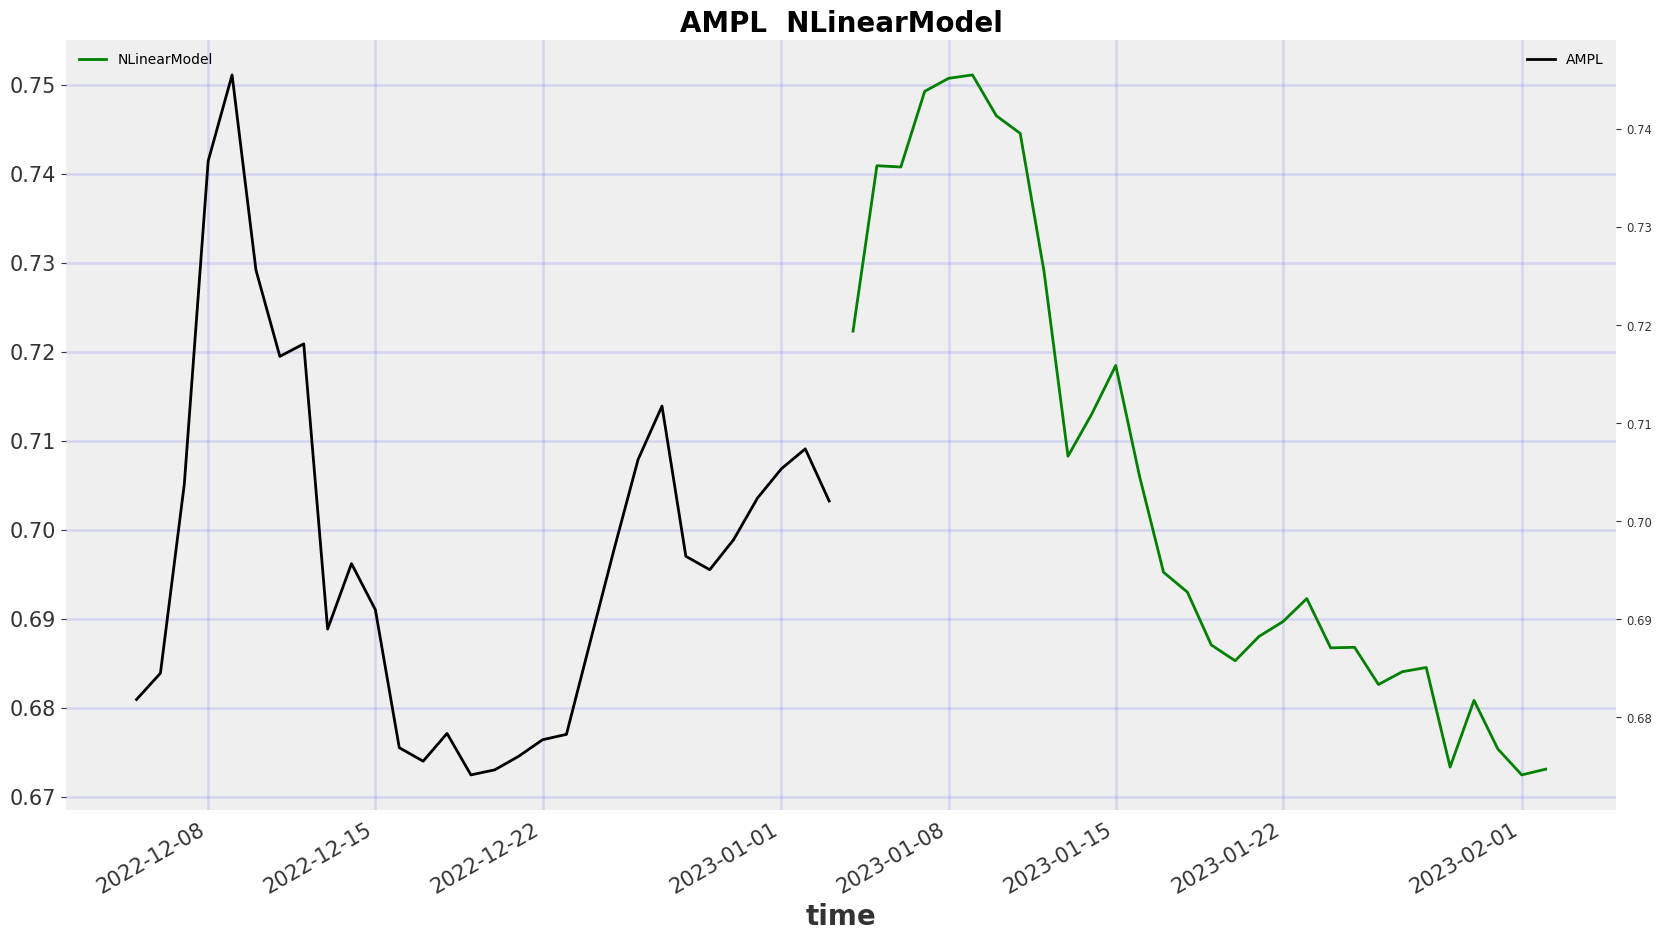

In [15]:
%matplotlib inline

# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
# %config InlineBackend.print_figure_kwargs={'edgecolor' : "w"}
# plt.rcParams['axes.facecolor'] = 'w'
# plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['savefig.facecolor'] = 'w'


fig, ax_left = plt.subplots(figsize=(20,10))
ax_right = ax_left.twinx()


train_plot.plot(ax=ax_left, linewidth=2, color="black")


pred.plot(ax=ax_right, linewidth=2, color="green")

ax_left.xaxis.label.set_size(20)
ax_left.yaxis.label.set_size(20)
ax_left.tick_params(axis='both', which='both', labelsize=15)
ax_left.set_title(ticker + "  " + currentModel , fontsize=20, fontweight="bold")
ax_left.grid(color='b', linestyle='-', linewidth=2, which='both', alpha=0.1)
ax_left.set_facecolor((0.8,0.8,0.8, 0.3))
ax_left.grid(True)
ax_right.grid(False)
ax_right.xaxis.label.set_size(20)
ax_right.yaxis.label.set_size(20)

ax_left.legend([ticker])
ax_right.legend([
    currentModel
], loc=2)
